<a href="https://colab.research.google.com/github/SaraSanGar/redes-neuronales/blob/main/Monkeys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconocedor de razas de mono

 Nuestra red neuronal es capaz de separar correctamente 5 razas de monos (Emperor Tamarin, Bald Uakari, Mandril, Proboscis y White face saki). Hemos probados varias combinaciones de capas para mejorar la acertividad de la red a la hora de separar las razas. La mejor combinación hallada es la que se utiliza en este código, y ha cosegido un 91% de exactitud.

A continuación muestramos ejemplos de otras combinaciones de capas que hemos probado:

**Modelo 1:**
Cambiamos el maxPooling: pool size (2, 2)
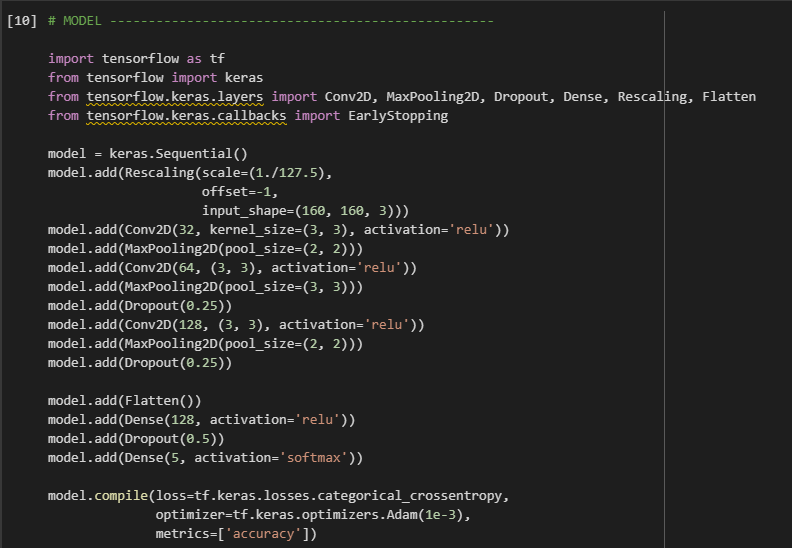
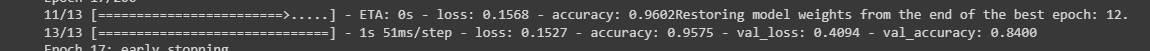
------------------------------------------------------------------
**Modelo 2:**
Cambiamos el kernel size (5, 5)
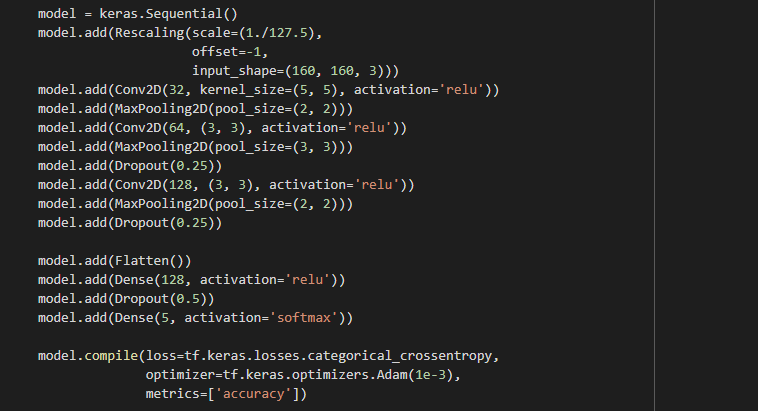
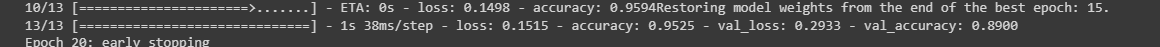
-----------------------------------------------------------------------
**Modelo 3:**
Disminuimos a la mitad el número de neuronas de todas las capas convolucionales.
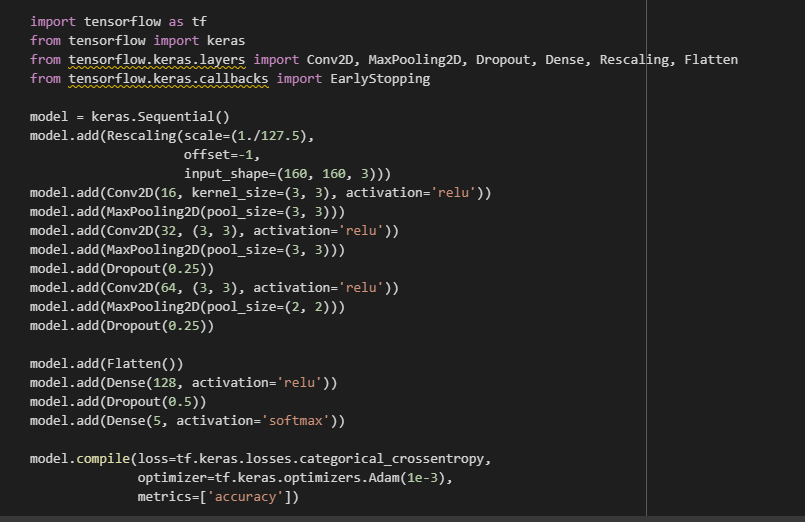
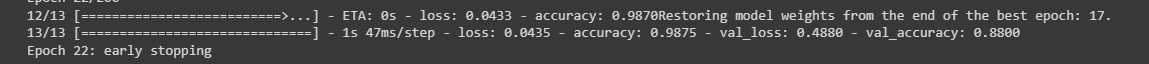

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Veamos una imagen de ejemplo.

Monkeys  Sign-Language


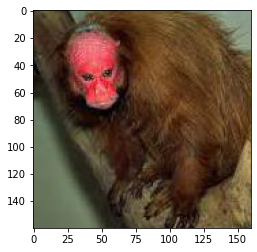

In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks/datasets/"

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/Monkeys/Bald Uakari/BU (23).jpeg', 'r')
imshow(np.asarray(pil_im))



## Primer modelo

In [ ]:
# DATA SOURCE --------------------------------------------------

image_size = (160, 160)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/datasets/Monkeys",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/datasets/Monkeys",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Found 500 files belonging to 5 classes.
Using 400 files for training.
Found 500 files belonging to 5 classes.
Using 100 files for validation.


In [ ]:
# MODEL --------------------------------------------------

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten
from tensorflow.keras.callbacks import EarlyStopping

model = keras.Sequential()
model.add(Rescaling(scale=(1./127.5),
                    offset=-1, 
                    input_shape=(160, 160, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [ ]:
# TRAINING --------------------------------------------------

epochs = 200

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True)

h = model.fit(
        train_ds,
        epochs=epochs, 
        validation_data=val_ds,
        callbacks = [es]
)

Epoch 1/200
13/13 [==============================] - 34s 2s/step - loss: 1.5844 - accuracy: 0.2875 - val_loss: 1.4633 - val_accuracy: 0.4200
Epoch 2/200
13/13 [==============================] - 1s 46ms/step - loss: 1.3034 - accuracy: 0.4525 - val_loss: 0.9307 - val_accuracy: 0.7200
Epoch 3/200
13/13 [==============================] - 1s 46ms/step - loss: 1.0682 - accuracy: 0.5775 - val_loss: 0.8464 - val_accuracy: 0.7100
Epoch 4/200
13/13 [==============================] - 1s 42ms/step - loss: 0.8934 - accuracy: 0.6375 - val_loss: 0.6855 - val_accuracy: 0.8100
Epoch 5/200
13/13 [==============================] - 1s 45ms/step - loss: 0.7783 - accuracy: 0.6900 - val_loss: 0.6756 - val_accuracy: 0.7000
Epoch 6/200
13/13 [==============================] - 1s 45ms/step - loss: 0.7497 - accuracy: 0.7125 - val_loss: 0.5733 - val_accuracy: 0.8200
Epoch 7/200
13/13 [==============================] - 1s 46ms/step - loss: 0.6549 - accuracy: 0.7550 - val_loss: 0.4851 - val_accuracy: 0.8300
Epoch 8

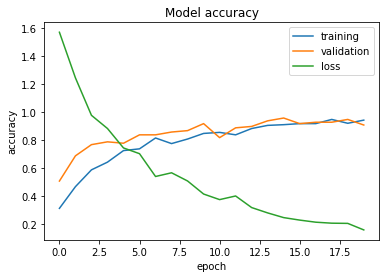

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right')
plt.show()

## Evaluación de los resultados

1/1 [==============================] - 0s 67ms/step
              precision    recall  f1-score   support

           0     0.9500    1.0000    0.9744        19
           1     1.0000    0.9091    0.9524        22
           2     0.8235    1.0000    0.9032        14
           3     1.0000    1.0000    1.0000        19
           4     1.0000    0.9231    0.9600        26

    accuracy                         0.9600       100
   macro avg     0.9547    0.9664    0.9580       100
weighted avg     0.9658    0.9600    0.9607       100



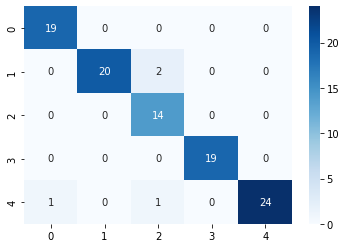

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in val_ds], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

In [ ]:
img = keras.preprocessing.image.load_img(
    '/content/drive/My Drive/Colab Notebooks/datasets/Monkeys/Emperor Tamarin/ET (32).jpeg', target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(np.argmax(predictions[0]))

1/1 [==============================] - 0s 23ms/step
1
